In [ ]:
!pip install tensorflow
!pip install matplotlib pillow tqdm


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving style.jpg to style.jpg
Saving content.jpg to content.jpg


In [ ]:
content_image_path = 'content.jpg'  # Replace with your uploaded content image filename
style_image_path = 'style.jpg'      # Replace with your uploaded style image filename


In [ ]:
content_image = Image.open(content_image_path)

# Load the style image
style_image = Image.open(style_image_path)

print("Content image loaded:", content_image.format, content_image.size, content_image.mode)
print("Style image loaded:", style_image.format, style_image.size, style_image.mode)

Content image loaded: JPEG (2349, 1763) RGB
Style image loaded: JPEG (960, 760) RGB


In [ ]:
try:
    # Load the content image
    content_image = Image.open(content_image_path)

    # Load the style image
    style_image = Image.open(style_image_path)

    print("Content image loaded:", content_image.format, content_image.size, content_image.mode)
    print("Style image loaded:", style_image.format, style_image.size, style_image.mode)
except FileNotFoundError:
    print("Error: Make sure the image paths are correct and the images exist.")
    # Re-raise the exception to indicate failure
    raise

Content image loaded: JPEG (2349, 1763) RGB
Style image loaded: JPEG (960, 760) RGB


In [ ]:
def preprocess_image(image, max_dim):
    """Resizes and preprocesses an image for a neural network."""
    img = np.array(image)
    # Resize the image while maintaining aspect ratio
    long_side = max(img.shape)
    scale = max_dim / long_side
    new_size = (int(img.shape[1] * scale), int(img.shape[0] * scale))
    img = Image.fromarray(img).resize(new_size, Image.LANCZOS)

    img = np.array(img).astype(np.float32)
    # Convert to a TensorFlow tensor and add batch dimension
    img = tf.convert_to_tensor(img)
    img = tf.expand_dims(img, axis=0)
    # Normalize pixel values
    img = img / 255.0
    return img

# Apply preprocessing to content and style images
max_dimension = 512  # Choose a suitable maximum dimension
preprocessed_content_image = preprocess_image(content_image, max_dimension)
preprocessed_style_image = preprocess_image(style_image, max_dimension)

print("Preprocessed content image shape:", preprocessed_content_image.shape)
print("Preprocessed style image shape:", preprocessed_style_image.shape)

Preprocessed content image shape: (1, 384, 512, 3)
Preprocessed style image shape: (1, 405, 512, 3)


In [ ]:
# Load a pre-trained VGG19 model from tensorflow_hub
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Select content and style layers
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Create a Keras model that outputs the activations of the chosen layers
outputs = [vgg.get_layer(name).output for name in content_layers + style_layers]
model = tf.keras.Model([vgg.input], outputs)

print("VGG19 model loaded and configured.")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG19 model loaded and configured.


In [ ]:
def content_loss(content_features, generated_features):
    """Calculates the content loss between two feature maps."""
    return tf.reduce_mean(tf.square(content_features - generated_features))

def gram_matrix(input_tensor):
    """Computes the Gram matrix of an input tensor."""
    # Reshape the tensor to (batch_size, height*width, channels)
    input_shape = tf.shape(input_tensor)
    batch_size = input_shape[0]
    height = input_shape[1]
    width = input_shape[2]
    channels = input_shape[3]
    reshaped_tensor = tf.reshape(input_tensor, [batch_size, -1, channels])

    # Compute the Gram matrix
    gram = tf.matmul(reshaped_tensor, reshaped_tensor, transpose_a=True)
    return gram

def style_loss(style_features, generated_features):
    """Calculates the style loss between two feature maps."""
    # Compute Gram matrices
    style_gram = gram_matrix(style_features)
    generated_gram = gram_matrix(generated_features)

    # Calculate mean squared error between Gram matrices
    loss = tf.reduce_mean(tf.square(style_gram - generated_gram))

    # Normalize the loss
    input_shape = tf.shape(style_features)
    height = tf.cast(input_shape[1], tf.float32)
    width = tf.cast(input_shape[2], tf.float32)
    channels = tf.cast(input_shape[3], tf.float32)
    normalization_factor = height * width * channels
    normalized_loss = loss / (normalization_factor**2) # Normalize by the square of the number of elements

    return normalized_loss

print("Content loss, Gram matrix, and Style loss functions defined.")

Content loss, Gram matrix, and Style loss functions defined.


In [ ]:
def get_feature_maps(image_tensor, model, content_layers, style_layers):
    """
    Takes an image tensor and returns a dictionary of feature maps from
    the defined content and style layers of the VGG19 model.
    """
    # Preprocess the input image
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(image_tensor * 255.0) # Scale back to 0-255

    # Pass the preprocessed image through the model
    outputs = model(preprocessed_input)

    # Organize the raw outputs into a dictionary
    feature_maps = {}
    layer_names = content_layers + style_layers
    for name, output in zip(layer_names, outputs):
        feature_maps[name] = output

    return feature_maps

def total_loss(model, loss_weights, content_image, style_image, generated_image, content_layers, style_layers, content_weight, style_weight):
    """
    Calculates the total loss as a weighted sum of content and style losses.
    """
    # Get feature maps for content, style, and generated images
    content_features = get_feature_maps(content_image, model, content_layers, style_layers)
    style_features = get_feature_maps(style_image, model, content_layers, style_layers)
    generated_features = get_feature_maps(generated_image, model, content_layers, style_layers)

    # Calculate content loss
    c_loss = content_loss(content_features[content_layers[0]], generated_features[content_layers[0]])

    # Calculate style loss
    s_loss = 0
    # Divide style weights by the number of style layers
    style_weights = {name: 1./len(style_layers) for name in style_layers}

    for name in style_layers:
        s_loss += style_weights[name] * style_loss(style_features[name], generated_features[name])

    # Calculate total loss
    total = content_weight * c_loss + style_weight * s_loss

    return total, c_loss, s_loss

print("Feature map extraction and total loss functions defined.")

Feature map extraction and total loss functions defined.


In [12]:
# 1. Define the optimization process
epochs = 2
steps_per_epoch = 30

# Create a TensorFlow variable for the generated image, initialized with the preprocessed content image.
# Using tf.Variable allows TensorFlow to track gradients with respect to this image.
generated_image = tf.Variable(preprocessed_content_image)

# Choose an optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Define content and style weights
content_weight = 1e3
style_weight = 1e-2

# 2. Implement the training loop
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        # Calculate the total loss
        loss, content_l, style_l = total_loss(model, None, preprocessed_content_image, preprocessed_style_image, image, content_layers, style_layers, content_weight, style_weight)

    # Calculate gradients
    grad = tape.gradient(loss, image)

    # Apply gradients
    optimizer.apply_gradients([(grad, image)])

    # Clip pixel values to be within the valid range [0, 1]
    image.assign(tf.clip_by_value(image, clip_value_min=0., clip_value_max=1.))

    return loss, content_l, style_l

# 3. Run the optimization
import time
start = time.time()

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        loss, content_l, style_l = train_step(generated_image)
        if m % 10 == 0: # Print progress every 10 steps
            print("Train step: {}".format(step))

    # Print epoch loss
    print("Epoch {}: Total Loss: {:.4e}, Content Loss: {:.4e}, Style Loss: {:.4e}".format(
        n+1, loss.numpy(), content_l.numpy(), style_l.numpy()))

end = time.time()
print("Total time: {:.1f} seconds".format(end-start))

# 4. The generated_image variable now holds the stylized image.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 384, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 405, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 384, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 405, 512, 3))
  warnings.warn(msg)
/usr

Train step: 1
Train step: 11
Train step: 21
Epoch 1: Total Loss: 1.1183e+05, Content Loss: 1.1081e+02, Style Loss: 1.0150e+05
Train step: 31
Train step: 41
Train step: 51
Epoch 2: Total Loss: 8.3483e+04, Content Loss: 8.1385e+01, Style Loss: 2.0979e+05
Total time: 727.4 seconds


In [13]:
def postprocess_image(image_tensor):
    """Converts a tensor to a displayable image format."""
    # Remove batch dimension
    image_tensor = tf.squeeze(image_tensor, axis=0)
    # Convert to uint8
    image_tensor = image_tensor * 255.0
    image_tensor = tf.cast(image_tensor, tf.uint8)
    # Convert to numpy array
    image_np = image_tensor.numpy()
    # Convert to PIL Image
    img = Image.fromarray(image_np)
    return img

# Postprocess the generated image
final_image = postprocess_image(generated_image)

# Save the final image (replace with your desired filename)
final_image_path = 'stylized_image.jpg'
final_image.save(final_image_path)

print(f"Stylized image saved to: {final_image_path}")

Stylized image saved to: stylized_image.jpg


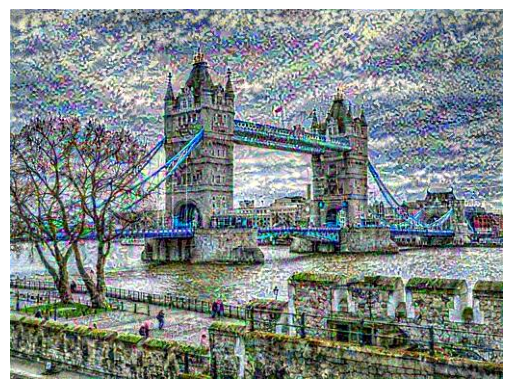

In [14]:
# Load and display the saved image
saved_image = Image.open(final_image_path)
plt.imshow(saved_image)
plt.axis('off')
plt.show()

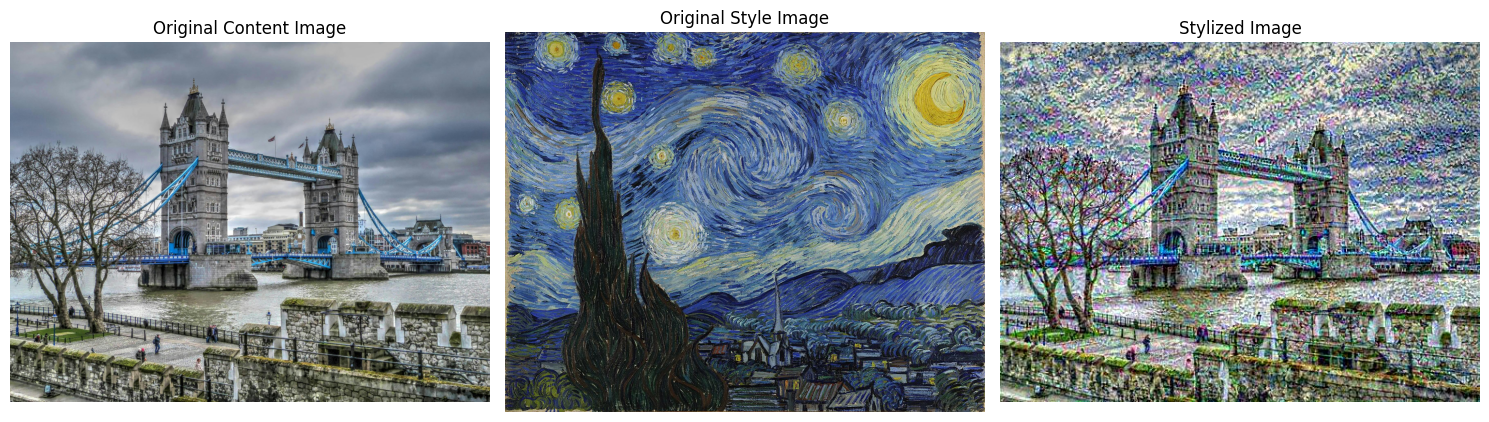

In [15]:
# Load the original content and style images again
original_content_image = Image.open(content_image_path)
original_style_image = Image.open(style_image_path)
stylized_image = Image.open(final_image_path)

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the images in the subplots
axes[0].imshow(original_content_image)
axes[0].set_title('Original Content Image')
axes[0].axis('off')

axes[1].imshow(original_style_image)
axes[1].set_title('Original Style Image')
axes[1].axis('off')

axes[2].imshow(stylized_image)
axes[2].set_title('Stylized Image')
axes[2].axis('off')

# Adjust layout to prevent titles from overlapping
plt.tight_layout()
plt.show()